In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error as mean_squared_error
import math
from config_notebooks.config import set_wd
set_wd()

In [23]:
df = pd.read_excel("./data/data.xlsx",index_col=0)[:"12-2022"]
# df = pd.read_excel("./data/data.xlsx",index_col=0)
df

,pp,pi,gap,er_cp,pre
2005-01-31,508.020737,86.866026,1.154717,896.478093,1423.333333
2005-02-28,500.539941,87.907449,1.160477,872.658808,969.666667
2005-03-31,656.181802,86.226525,1.170062,860.907091,1730.000000
2005-04-30,939.064907,87.964450,1.149008,863.177404,620.000000
2005-05-31,1028.823820,89.117152,1.121609,854.918192,54.666667
...,...,...,...,...,...
2022-08-31,1988.408046,200.959296,2.149003,369.796103,146.666667
2022-09-30,2071.879245,204.883577,2.071033,368.751129,106.666667
2022-10-31,2339.045364,205.876822,2.022584,368.460742,543.333333
2022-11-30,1506.227931,203.938464,1.958168,373.953314,670.000000


In [35]:
x_list = [
          "pi",
          "pre",
          "er_cp",
          "gap"
          ]
months_for_test = 6
months_to_predict = 6
alpha = .1
train = df[:-months_for_test].copy()
test = df.copy()

In [36]:
y_train = train["pp"]
y_test = test["pp"]
X_train =train[x_list]
X_test = test[x_list]

MODEL_ORDERS = { #Result of the model calibration
    'pp': {'order':(7,1,8), 'seasonal_order':(1,0,0,12)},
    'er_cp': {'order':(7,0,4), 'seasonal_order':None},
    'pi': {'order':(8,1,8), 'seasonal_order':(0,0,1,12)},
    'pre': {'order':(1,0,1), 'seasonal_order':(1,0,1,12)},
    'gap': {'order':(1,1,9), 'seasonal_order':None}
                }

1. Estimar las exogenas n meses en train (X_new_train)
2. Estimar las exogenas n meses en test (X_new_test)
3. Estimar la endógena n meses en train (usando X_new_train) 
4. Estimar la endógena n meses en test (usando X_new_test)

In [37]:
train_model_er_cp = SARIMAX(train[["er_cp"]],order = MODEL_ORDERS['er_cp']['order'], seasonal_order=MODEL_ORDERS['er_cp']['seasonal_order'])
train_model_pi = SARIMAX(train[["pi"]], order=MODEL_ORDERS['pi']['order'], seasonal_order=MODEL_ORDERS['pi']['seasonal_order'])
train_model_pre = SARIMAX(np.log(train[["pre"]]+1), order=MODEL_ORDERS['pre']['order'], seasonal_order=MODEL_ORDERS['pre']['seasonal_order'])
train_model_gap = SARIMAX(train[["gap"]], order=MODEL_ORDERS['gap']['order'], seasonal_order=MODEL_ORDERS['gap']['seasonal_order'])

test_model_er_cp = SARIMAX(test[["er_cp"]],order = MODEL_ORDERS['er_cp']['order'], seasonal_order=MODEL_ORDERS['er_cp']['seasonal_order'])
test_model_pi = SARIMAX(test[["pi"]], order=MODEL_ORDERS['pi']['order'], seasonal_order=MODEL_ORDERS['pi']['seasonal_order'])
test_model_pre = SARIMAX(np.log(test[["pre"]]+1), order=MODEL_ORDERS['pre']['order'], seasonal_order=MODEL_ORDERS['pre']['seasonal_order'])
test_model_gap = SARIMAX(test[["gap"]], order=MODEL_ORDERS['gap']['order'], seasonal_order=MODEL_ORDERS['gap']['seasonal_order'])

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\stat

In [40]:
features_models = {train_model_pi:"pi", train_model_pre:"pre", train_model_er_cp:"er_cp", train_model_gap:"gap"}
X_train =train[x_list]

for model in features_models:
    variable = features_models[model]
    order = MODEL_ORDERS[variable]["order"]
    seasonal_order = MODEL_ORDERS[variable]["seasonal_order"]
    seasonal_order = "" if not seasonal_order else seasonal_order
    fitted = model.fit()
    forecast = fitted.forecast(months_for_test)
    forecast = pd.concat([fitted.fittedvalues, forecast])
    if model == train_model_pre:
        forecast = np.exp(forecast) #Transformación de inversión
    obs_pred_df = pd.DataFrame({"observado":test[variable],
                                "prediccion": forecast})
    RMSE = round(math.sqrt(mean_squared_error(obs_pred_df["observado"], obs_pred_df["prediccion"])), 2)
    plot_predicc_obs_exog = go.Figure()
    # plot_predicc_obs_exog.add_trace(go.Scatter(x=obs_pred_df.index, y = obs_pred_df["observado"], name = "Observación"))
    plot_predicc_obs_exog.add_trace(go.Scatter(x=df.index, y = df[variable], name = "Observación"))
    plot_predicc_obs_exog.add_trace(go.Scatter(x=obs_pred_df.index, y = obs_pred_df["prediccion"], name = "Predicción"))
    plot_predicc_obs_exog.add_vline(x = obs_pred_df.index[-months_for_test], line_width=3, line_dash="dash", line_color="green")
    plot_predicc_obs_exog.update_layout(template = None, title_text =f"Testeo modelo para \"{variable}\"<br><sup>Modelo: {order}{seasonal_order}.",
    font_family = "georgia")
    plot_predicc_obs_exog.write_image(f"./output/testeo_exog_sarimax/testeo_exog_sarimax_{variable}.pdf")
    plot_predicc_obs_exog.show()

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [28]:
X_new_train = pd.DataFrame()
for modelo in features_models:
    fitted = modelo.fit(disp=False)
    forecast = fitted.forecast(months_for_test)
    # forecast = pd.concat([fitted.fittedvalues, forecast]) 
    if modelo == train_model_pre:
        forecast = np.exp(forecast)
    X_new_train[features_models[modelo]] = forecast
X_new_train = X_new_train[x_list]

X_new_test = pd.DataFrame()
for modelo in features_models:
    fitted = modelo.fit(disp=False)
    forecast = fitted.forecast(months_to_predict)
    # forecast = pd.concat([fitted.fittedvalues, forecast]) 
    if modelo == test_model_pre:
        forecast = np.exp(forecast)
    X_new_test[features_models[modelo]] = forecast
X_new_test = X_new_test[x_list]

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\stats

In [29]:
train_model_pp = SARIMAX(y_train, order=MODEL_ORDERS['pp']['order'], seasonal_order=MODEL_ORDERS['pp']['seasonal_order'],
                         exog=X_train)
test_model_pp = SARIMAX(y_test, order=MODEL_ORDERS['pp']['order'], seasonal_order=MODEL_ORDERS['pp']['seasonal_order'],
                        exog=X_test)

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



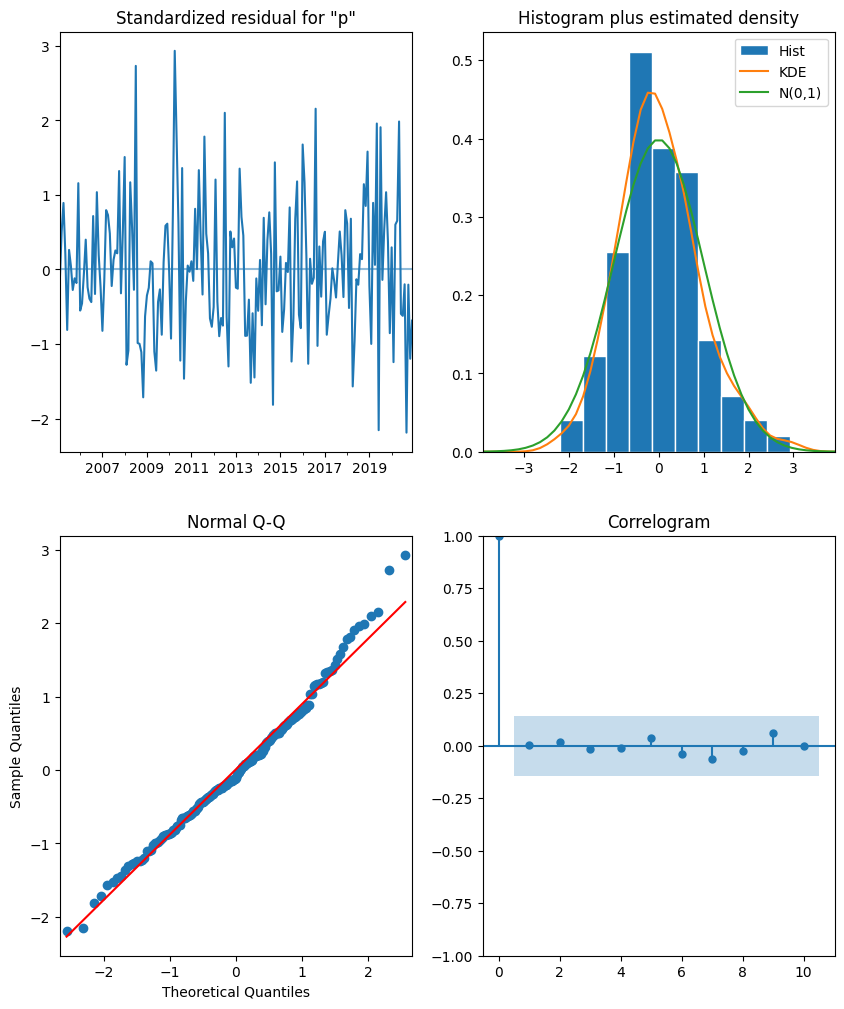

In [30]:
train_model_pp.fit().plot_diagnostics(figsize=(10, 12))
plt.show()

In [31]:
fitted = train_model_pp.fit(disp=False)
order_main = MODEL_ORDERS["pp"]["order"]
seasonal_order_main = MODEL_ORDERS["pp"]["seasonal_order"]
forecast_train = fitted.forecast(months_for_test, exog = X_new_train)
forecast_train = pd.concat([fitted.fittedvalues, forecast_train])
obs_pred_df = pd.DataFrame({"observado":y_test,
                            "prediccion": forecast_train})
RMSE = round(math.sqrt(mean_squared_error(obs_pred_df["observado"], obs_pred_df["prediccion"])), 2)
plot_predicc_obs_exog = go.Figure()
plot_predicc_obs_exog.add_trace(go.Scatter(x=y_test.index, y = y_test, name = "Observación"))
plot_predicc_obs_exog.add_trace(go.Scatter(x=obs_pred_df.index, y = obs_pred_df["prediccion"], name = "Predicción"))
plot_predicc_obs_exog.add_vline(x = obs_pred_df.index[-months_for_test], line_width=3, line_dash="dash", line_color="green")
plot_predicc_obs_exog.update_layout(template = None, title_text =f"Testeo del modelo para \"{'pp'}\"<br><sup>{order_main}{seasonal_order_main}. RMSE: {RMSE}",
font_family = "georgia")
plot_predicc_obs_exog.write_image("./output/testeo_exog_sarimax/testeo_endog_sarimax_pp.pdf")
plot_predicc_obs_exog.show()

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [32]:
order_main

(7, 1, 8)

In [33]:
fitted = test_model_pp.fit(disp=False)
# forecast_test = fitted.forecast(months_to_predict, exog = X_new_test)
forecast_test = fitted.get_forecast(months_to_predict, exog = X_new_test)
forecast_test = forecast_test.summary_frame(alpha=alpha)[["mean", "mean_ci_lower", "mean_ci_upper"]]
forecast_test = pd.concat([fitted.fittedvalues, forecast_test])
obs_pred_test = pd.DataFrame({"observado":y_test,
                            "prediccion": forecast_test["mean"],
                            'predicted_lower' : forecast_test["mean_ci_lower"],
                            'predicted_upper' : forecast_test["mean_ci_upper"],
                            })
plot_predicc_obs_exog = go.Figure()
plot_predicc_obs_exog.add_trace(go.Scatter(x=y_test.index, y = y_test, name = "Observación"))
plot_predicc_obs_exog.add_trace(go.Scatter(x=obs_pred_test.index, y = obs_pred_test["prediccion"], name = "Predicción"))
plot_predicc_obs_exog.add_trace(go.Scatter(x = obs_pred_test.index[-months_to_predict:], y = obs_pred_test.predicted_lower[-months_to_predict:], name = "Predicción_lower"))
plot_predicc_obs_exog.add_trace(go.Scatter(x = obs_pred_test.index[-months_to_predict:], y = obs_pred_test.predicted_upper[-months_to_predict:], name = "Predicción_upper", fill='tonexty'))
plot_predicc_obs_exog.add_vline(x = obs_pred_test.index[-months_to_predict], line_width=3, line_dash="dash", line_color="green")
plot_predicc_obs_exog.update_layout(template = None, 
                                    height = 300,
                                    margin = dict(l=30, b=30, t=28),
                                    title_text =f"Predicción a 6 meses usando modelo SARIMAX \"{'pp'}\"<br><sup>Modelo: {order_main}{seasonal_order_main}. Nivel de confianza: {1-alpha:.0%}",
font_family = "georgia")
plot_predicc_obs_exog.write_image("./output/Prediccion_sarimax_plot.pdf")
plot_predicc_obs_exog.show()

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

